# 1、定义算法
DDPG ( Deep Deterministic Policy Gradient )，看起来似乎是一个基于 Policy Gradient 的算法，但实际上在实现的时候更像是 AC + DQN ，
有别于 DQN 只支持离散动作，DDPG 主要是为了支持连续性的动作，和 DQN 相似的点有很多，例如：

- 同样采用了经验回放池，用于对样本的收集和再利用

- 在更新网络时，同样也使用 target 网络，即先固定一个网络的参数，在一定次数的更新后，将新的参数更新至 target 网络进行更新。

- 在 critic 网络中，需要同时输入 state 和 action，输出一个类似于DQN 中 Q value 的值

而和 DQN 比较大的一个差异是，在选择动作时，没有使用基础的 $\epsilon$ -greedy ，而是加入了基于 OU ( Ornstein–Uhlenbeck ) 噪声的一种采样动作的方法。OU 噪声相关的论文链接如下：
[https://djalil.chafai.net/docs/M2/history-brownian-motion/Uhlenbeck%20&%20Ornstein%20-%201930.pdf](https://djalil.chafai.net/docs/M2/history-brownian-motion/Uhlenbeck%20&%20Ornstein%20-%201930.pdf)

## 1.1 定义模型

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Actor(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim, init_w=3e-3):
        '''
        actor 模型的结构定义
        Args:
            n_states (int): 输入状态的维度
            n_actions (int): 可执行动作的数量
            hidden_dim (int): 隐含层数量
            init_w (float, optional): 均匀分布初始化权重的范围
        '''
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(n_states, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, n_actions)

        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x


class Critic(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim, init_w=3e-3):
        '''
        critic 模型的结构定义
        Args:
            n_states (int): 输入状态的维度
            n_actions (int): 可执行动作的数量
            hidden_dim (int): 隐含层数量
            init_w (float, optional): 均匀分布初始化权重的范围
        '''
        super(Critic, self).__init__()

        self.linear1 = nn.Linear(n_states + n_actions, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        # 随机初始化为较小的值
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)

    def forward(self, state, action):
        # 按维数1拼接
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x


class OUNoise(object):
    '''
    构造 Ornstein–Uhlenbeck 噪声的类
    https://djalil.chafai.net/docs/M2/history-brownian-motion/Uhlenbeck%20&%20Ornstein%20-%201930.pdf
    '''

    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        '''
        初始化输入参数
        Args:
            action_space (gym.spaces.box.Box): env 中的 action_space
            mu (float, optional): 噪声均值
            theta (float, optional): 系统对噪声的扰动程度，theta 越大，噪声扰动越小
            max_sigma (float, optional): 最大 sigma，用于更新衰变 sigma 值
            min_sigma (float, optional): 最小 sigma，用于更新衰变 sigma 值
            decay_period (int, optional): 衰变周期
        '''
        self.mu = mu
        self.theta = theta
        self.sigma = max_sigma
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period
        self.n_actions = action_space.shape[0]  # env环境中可执行动作的数量，因是连续动作，所以一般为1
        self.low = action_space.low  # env环境中动作取值的最小值
        self.high = action_space.high  # env环境中动作取值的最大值
        self.reset()

    def reset(self):
        '''
        重置噪声
        '''
        self.obs = np.ones(self.n_actions) * self.mu  # reset the noise

    def evolve_obs(self):
        '''
        更新噪声
        Returns:
            返回更新后的噪声值
        '''
        x = self.obs
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.n_actions)  # Ornstein–Uhlenbeck process
        self.obs = x + dx
        return self.obs

    def get_action(self, action, t=0):
        '''
        根据输入的动作，输出加入 OU 噪声后的动作
        Args:
            action (np.ndarray[float]): 输入的动作值
            t (int, optional): 当前环境已执行的帧数

        Returns:
            action (np.ndarray[float]): 返回加入 OU 噪声后的动作
        '''
        ou_obs = self.evolve_obs()
        ## 根据env进程（t），通过设定的衰变周期（decay_period），进行更新衰变的sigma值
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_obs, self.low, self.high)  # add noise to action

## 1.2 经验回放池

In [2]:

import random
from collections import deque

class ReplayBufferQue:
    def __init__(self, cfg) -> None:
        self.capacity = cfg.buffer_size
        self.buffer = deque(maxlen=self.capacity)
        
    def push(self,transitions):
        '''_summary_
        Args:
            trainsitions (tuple): _description_
        '''
        self.buffer.append(transitions)
        
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if sequential: # sequential sampling
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else:
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
        
    def clear(self):
        self.buffer.clear()
        
    def __len__(self):
        return len(self.buffer)


## 1.3 算法

In [3]:

class DDPG:
    def __init__(self, cfg, memory, actor, critic, ou_noise):
        '''
        构建智能体
        Args:
            cfg (class): 超参数类 AlgoConfig
        '''
        self.action_space = cfg.action_space  # env 中的 action_space
        self.ou_noise = ou_noise # 实例化 构造 Ornstein–Uhlenbeck 噪声的类
        self.batch_size = cfg.batch_size
        self.gamma = cfg.gamma
        self.tau = cfg.tau
        self.sample_count = 0  # 记录采样动作的次数
        self.update_flag = False  # 标记是否更新网络
        self.device = torch.device(cfg.device)
        self.critic = critic
        self.target_critic = critic
        self.actor = actor
        self.target_actor = actor
        ## 将 critc 网络的参数赋值给target critic 网络
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        ## 将 actor 网络的参数赋值给target actor 网络
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=cfg.critic_lr)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=cfg.actor_lr)
        self.memory = memory
            
    def sample_action(self, state):
        '''
        根据输入的状态采样动作
        Args:
            state (np.ndarray): 输入的状态

        Returns:
            action (np.ndarray[float]): 根据状态采样后的动作
        '''
        self.sample_count += 1
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        action_tanh = self.actor(state)  # action_tanh is in [-1, 1]
        # convert action_tanh to action in the original action space
        action_scale = torch.FloatTensor((self.action_space.high - self.action_space.low) / 2.).to(self.device)
        action_bias = torch.FloatTensor((self.action_space.high + self.action_space.low) / 2.).to(self.device)
        action = action_scale * action_tanh + action_bias
        action = action.cpu().detach().numpy()[0]
        # add noise to action
        action = self.ou_noise.get_action(action, self.sample_count)
        return action

    @torch.no_grad()
    def predict_action(self, state):
        '''
        根据输入的状态预测下一步的动作
        Args:
            state (np.ndarray):  输入的状态

        Returns:
            action (np.ndarray[float]): 根据状态采样后的动作
        '''
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        action_tanh = self.actor(state)  # action_tanh is in [-1, 1]
        # convert action_tanh to action in the original action space
        action_scale = torch.FloatTensor((self.action_space.high - self.action_space.low) / 2.).to(self.device)
        action_bias = torch.FloatTensor((self.action_space.high + self.action_space.low) / 2.).to(self.device)
        action = action_scale * action_tanh + action_bias
        action = action.cpu().detach().numpy()[0]
        return action

    def update(self, share_agent=None):
        ## 当经验回放池中的数量小于 batch_size 时，直接返回不更新
        if len(self.memory) < self.batch_size:  # when memory size is less than batch size, return
            return
        else:
            if not self.update_flag:
                print("Begin to update!")
                self.update_flag = True
        ## 从经验回放池中采样 batch_size 个样本
        state, action, reward, next_state, done = self.memory.sample(self.batch_size)
        ## 将状态、动作等 array 转为 tensor
        state = torch.FloatTensor(np.array(state)).to(self.device)
        next_state = torch.FloatTensor(np.array(next_state)).to(self.device)
        action = torch.FloatTensor(np.array(action)).to(self.device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(self.device)
        done = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(self.device)
        ## 输入状态及通过 actor 网络 根据该状态输出的动作，计算 critic 网络输出的价值，类似于DQN中的q-value
        policy_loss = self.critic(state, self.actor(state))
        ## 计算均值作为 critic 网络的损失
        policy_loss = -policy_loss.mean()
        ## 根据下一个 time step 的状态用 target_actor 网络输出目标动作
        next_action = self.target_actor(next_state)
        ## 输入下一个 time step 的状态及目标动作，计算 target_critc 网络输出的目标价值
        target_value = self.target_critic(next_state, next_action.detach())
        ## 根据真实奖励更新目标价值
        expected_value = reward + (1.0 - done) * self.gamma * target_value
        expected_value = torch.clamp(expected_value, -np.inf, np.inf)
        ## 输入状态和动作，用 critic 网络计算预估的价值
        value = self.critic(state, action)
        ## 将 critic 网络输出的价值和 target_critic输出并更新后的价值通过MSE进行损失计算
        value_loss = nn.MSELoss()(value, expected_value.detach())

        ## 更新 actor 网络参数
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        ## 更新 critic 网络参数
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()
        ## 通过软更新的方法，缓慢更新 target critic 网络的参数
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) +
                param.data * self.tau
            )
        ## 通过软更新的方法，缓慢更新 target actor 网络的参数
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) +
                param.data * self.tau
            )

    def save_model(self, fpath):
        '''
        保存模型
        Args:
            fpath (str): 模型存放路径
        '''
        from pathlib import Path
        # create path

        Path(fpath).mkdir(parents=True, exist_ok=True)
        torch.save(self.actor.state_dict(), f"{fpath}/actor_checkpoint.pt")

    def load_model(self, fpath):
        '''
        根据模型路径导入模型
        Args:
            fpath (str): 模型路径
        '''
        actor_ckpt = torch.load(f"{fpath}/actor_checkpoint.pt", map_location=self.device)
        self.actor.load_state_dict(actor_ckpt)


# 2. 定义训练

In [4]:
def train(cfg, env, agent):
    print("开始训练！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state, info = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.sample_action(state)  # 选择动作

            next_state, reward, terminated, truncated , info = env.step(action)  # 更新环境，返回transition
            agent.memory.push((state, action, reward, next_state, terminated))  # 保存transition
            state = next_state  # 更新下一个状态
            agent.update()  # 更新智能体
            ep_reward += reward  # 累加奖励
            if terminated:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}")
    print("完成训练！")
    env.close()
    return {'rewards':rewards}

def test(cfg, env, agent):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state, info = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step+=1
            action = agent.predict_action(state)  # 选择动作
            next_state, reward, terminated, truncated , info = env.step(action)  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if terminated:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    print("完成测试")
    env.close()
    return {'rewards':rewards}

# 3. 定义环境

In [5]:
import gymnasium as gym
import os

def all_seed(seed = 1):
    ''' 万能的seed函数
    '''
    if seed == 0: # 不设置seed
        return 
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

def env_agent_config(cfg):
    env = gym.make(cfg.env_id) # 创建环境
    all_seed(seed=cfg.seed)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    print(f"状态空间维度：{state_dim}，动作空间维度：{action_dim}")
    setattr(cfg,"action_space", env.action_space) # 更新 action_space 到 cfg 参数中
    memory = ReplayBufferQue(cfg)  # 实例化经验回放池
    actor = Actor(state_dim, action_dim, hidden_dim=cfg.actor_hidden_dim).to(cfg.device)  # 实例化 actor 模型
    critic = Critic(state_dim, action_dim, hidden_dim=cfg.critic_hidden_dim).to(cfg.device)  # 实例化 critic 模型
    ou_noise = OUNoise(env.action_space)
    agent = DDPG(cfg, memory, actor, critic, ou_noise)
    return env, agent

# 4. 定义参数

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

class Config:
    def __init__(self) -> None:
        self.algo_name = 'DDPG' # 算法名称
        self.env_id = 'MountainCarContinuous-v0' # 环境id
        self.seed = 1 # 随机种子，便于复现，0表示不设置
        self.train_eps = 100 # 训练的回合数
        self.test_eps = 20 # 测试的回合数
        self.max_steps = 500 # 每个回合的最大步数，超过该数则游戏强制终止
        self.gamma = 0.95  # 贴现因子，值越大，表示未来的收益占更大的比重
        self.critic_lr = 1e-3  # critic 模型的学习率
        self.actor_lr = 1e-3  # actor 模型的学习率
        self.buffer_size = 5000  # 经验回放池的大小
        self.batch_size = 256  # 训练 actor 及 critic 模型的 batch 大小
        self.tau = 0.01  # 软更新参数，值越小，表示在更新目标网络参数时，参数变化越小
        self.critic_hidden_dim = 128  # critic 网络的隐含层数
        self.actor_hidden_dim = 128  # actor 网络的隐含参数
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 检测gpu
        
def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    ''' 画图
    '''
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_id}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()


# 5. 开始训练

状态空间维度：2，动作空间维度：1
开始训练！
Begin to update!
回合：10/100，奖励：-36.92
回合：20/100，奖励：76.40
回合：30/100，奖励：-38.25
回合：40/100，奖励：-36.46
回合：50/100，奖励：-36.12
回合：60/100，奖励：-33.18
回合：70/100，奖励：-33.74
回合：80/100，奖励：-34.21
回合：90/100，奖励：-35.92
回合：100/100，奖励：-37.29
完成训练！


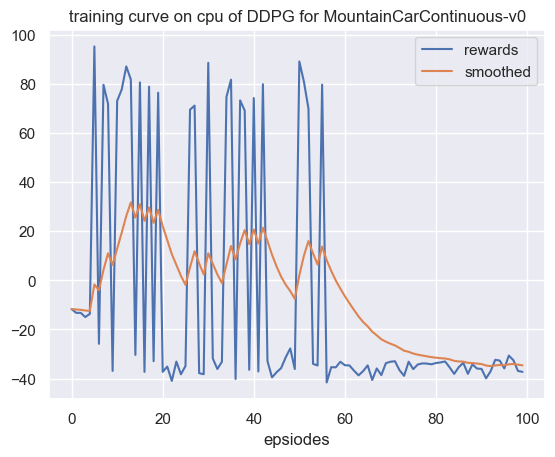

开始测试！
回合：1/20，奖励：-50.00
回合：2/20，奖励：-50.00
回合：3/20，奖励：-50.00
回合：4/20，奖励：-50.00
回合：5/20，奖励：-50.00
回合：6/20，奖励：-50.00
回合：7/20，奖励：-50.00
回合：8/20，奖励：-50.00
回合：9/20，奖励：-50.00
回合：10/20，奖励：-50.00
回合：11/20，奖励：-50.00
回合：12/20，奖励：-50.00
回合：13/20，奖励：-50.00
回合：14/20，奖励：-50.00
回合：15/20，奖励：-50.00
回合：16/20，奖励：-50.00
回合：17/20，奖励：-50.00
回合：18/20，奖励：-50.00
回合：19/20，奖励：-50.00
回合：20/20，奖励：-50.00
完成测试


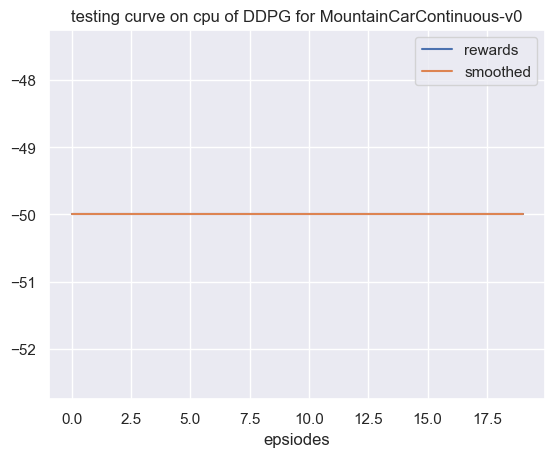

In [9]:
# 获取参数
cfg = Config() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果